In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

from sklearn.utils import shuffle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
class Dataset(object):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def get_next_batch(self, batch_size):
        self.features, self.labels = shuffle(self.features, self.labels)
        return self.features[0:batch_size,:], self.labels[0:batch_size,:]
        
        
class Data(object):
    def __init__(self, features, labels):
        
        partition = features.shape[0] / 4
        
        train_features = features[0:partition*3,:]
        train_labels = labels[0:partition*3,:]
        
        test_features = features[partition*3:partition*4,:]
        test_labels = labels[partition*3:partition*4,:]
        
        self.train = Dataset(train_features, train_labels)
        self.test = Dataset(test_features, test_labels)
        

def load_matrix_from_disk(folder, name):
    matrix = np.load(folder + "/" + name + ".npy")
    return matrix

loaded_features = load_matrix_from_disk("./MY_data", "features")
loaded_labels = load_matrix_from_disk("./MY_data", "labels")

data = Data(loaded_features, loaded_labels)

In [4]:
IMAGE_SIZE = 32
DEPTH = 3
CLASSES = 4

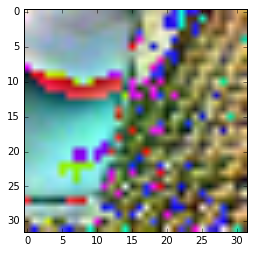

In [5]:
a, b = data.test.get_next_batch(1)
plt.imshow(a.reshape((IMAGE_SIZE, IMAGE_SIZE, DEPTH)))
plt.show()

In [6]:
TESTS = 1000

# x and y coordinates to plot 
x_coordinates = np.linspace(0, TESTS, num=TESTS)
loss_y_coordinates = np.zeros(TESTS)
accuracy_y_coordinates = np.zeros(TESTS)

def plot(x, y, limits, title, x_label_name, y_label_name):
    plt.close("all")
    figure = plt.figure()
    figure.clf()
    
    plt.plot(x, y)
    
    #plt.axis(limits)
    plt.ylabel(y_label_name)
    plt.xlabel(x_label_name)

    figure.suptitle(title, fontsize=20)
    plt.legend(loc='upper right')
    
    plt.show()
    return

def scatter(x, y, limits, title, x_label_name, y_label_name):
    plt.close("all")
    figure = plt.figure()
    figure.clf()
    
    plt.scatter(x, y)
    
    #plt.axis(limits)
    plt.ylabel(y_label_name)
    plt.xlabel(x_label_name)

    figure.suptitle(title, fontsize=20)
    plt.legend(loc='upper right')
    
    plt.show()
    return

def plot_cross_entropy():
    limits = [0,None,0,5]
    plot(x_coordinates, loss_y_coordinates, limits, "Validation Set Cross Entropy", "Validation Images", "Entropy")  
    return

def plot_accuracy():
    limits = [0,None,0,1]
    scatter(x_coordinates, accuracy_y_coordinates, limits, "Validation Set Accuracy", "Validation Images", "Accuracy")
    return

In [7]:
trained_graph_path = "./Trained_Model/trained_graph.pb"

with tf.Graph().as_default() as this_graph:
    trained_graph = tf.GraphDef()
    with open(trained_graph_path, "rb") as f:
        trained_graph.ParseFromString(f.read())
        tf.import_graph_def(trained_graph, name="")

    with tf.Session() as sess:
       
        for test in range(TESTS):
            # MNIST tests
            #features = mnist.validation.images[test].reshape((1,784))
            #target = mnist.validation.labels[test].reshape((1,10))
            
            # Mydata tests
            features, target = data.test.get_next_batch(1)
            features = features.reshape((1,IMAGE_SIZE * IMAGE_SIZE * DEPTH))
            target = target.reshape((1,CLASSES))

            predictions_vector = sess.graph.get_tensor_by_name("fully_connected_output/output_node:0")
            prediction = sess.run(predictions_vector, feed_dict={"features_matrix:0": features})
            accuracy = np.argmax(target) == np.argmax(prediction)
            accuracy_y_coordinates[test] = accuracy  
            
        tf.merge_all_summaries()
        tf.train.SummaryWriter('./TensorBoard/',graph=this_graph)

/home/isai/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


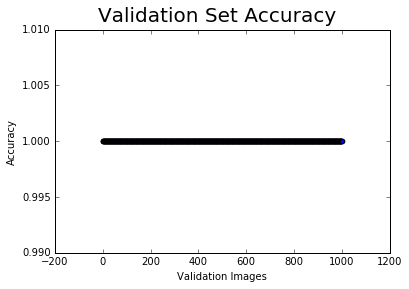

In [8]:
plot_accuracy()

In [9]:
mean_accuracy = np.mean(accuracy_y_coordinates)

print("Test Set Mean Accuracy")
print(mean_accuracy)

Test Set Mean Accuracy
1.0


In [10]:
# mnist filter size 3 = 0.951 accuracy
# mnist filter size 5 = 0.957 accuracy
# mnist filter size 7 = 0.954 accuracy
# mnist filter size 9 = 0.937 accuracy
# mnist filter size 11 = 0.935 accuracy

# selected = filter size of 5

In [11]:
# my_numbers learning rate 0.0001 = 0.403 accuracy
# my_numbers learning rate 0.001  = 0.45 accuracy but with more epochs accuracy decreases
# my_numbers learning rate 0.01   = 0.42 accuracy
# my_numbers learning rate 0.1    = 0.39 accuracy

# selected learning rate of 0.001

In [12]:
# my_numbers epochs 5000 = 0.395 accuracy
# my_numbers epochs 10000 = 0.395 accuracy
# 10000 epochs and lr 0.001 = 0.375